# Music Generation - Siddharth Shah, Ian Pompliano

Artificial Neural Networks and Deep Learning Final Project (Fall 2023)

**Part 1: Scrape MIDI files.**

In [1]:
import requests
import os
from bs4 import BeautifulSoup
from music21 import *

In [2]:
# list of composers
composers = ["albeniz", "bach", "balak", "beeth", "borodin", "brahms", "burgm",
             "chopin", "clementi", "debuss", "godowsky", "grana", "grieg", "haydn",
             "liszt", "mendelssohn", "moszkowski", "mozart", "muss", "rach", "ravel",
             "schub", "schum", "sinding", "tschai"]

baseURL = 'http://www.piano-midi.de/'

# create a directory to save downloaded MIDI files
if not os.path.exists('midiFiles'):
    os.makedirs('midiFiles')

for composer in composers:
    # create URL using respective composer
    url = baseURL + composer + '.htm'
    response = requests.get(url)

    soup = BeautifulSoup(response.content, 'html.parser')

    # Find MIDI links on the composer's page
    midiLinks = soup.find_all('a', href=True)

    for link in midiLinks:
        # removes duplicate MIDI files (special format0)
        if link['href'].endswith('.mid') and '_format0' not in link['href']:
            midiURL = baseURL + link['href']
            fileName = f"midiFiles/{composer}_{link['href'].split('/')[-1]}"

            # download MIDI file and save it to directory
            with open(fileName, 'wb') as midiFile:
                midiResponse = requests.get(midiURL)
                midiFile.write(midiResponse.content)

**Part 2: Organize notes in each MIDI file. Create list of sublists containing notes for each song**

In [3]:
# helper function to get the notes in a given MIDI file
def getNotes(file):
    # initalize list of notes to return
    notes = []
    pick = file.recurse()

    for element in pick:
        # if element is note, add to list of notes
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        # if element is chord, add highest pitch (generally belongs to melody) to list of notes.
        elif isinstance(element, chord.Chord):
            highestPitch = max(element.pitches)
            notes.append(str(highestPitch))
    return notes

In [4]:
# initialize list that will hold sub-lists of notes for each song
allNotes = []

# retrieve paths of MIDI files
midiFiles = [os.path.join('midiFiles', file) for file in os.listdir('midiFiles') if file.endswith('.mid')]

# append allNotes with note data for each song
for path in midiFiles:
    midi = converter.parse(path)
    notes = getNotes(midi)
    allNotes.append(notes)

/Users/ianpompliano/anaconda3/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2007 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/Users/ianpompliano/anaconda3/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1998 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
/Users/ianpompliano/anaconda3/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2004 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
/Users/ianpompliano/anaconda3/lib/python3.11/site-packages/music21/midi/translate.py:87

/Users/ianpompliano/anaconda3/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2001 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
/Users/ianpompliano/anaconda3/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2006 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
/Users/ianpompliano/anaconda3/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1996 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/Users/ianpompliano/anaconda3/lib/python3.11/site-packages/music21/midi/translate.py:87

/Users/ianpompliano/anaconda3/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Et\xfcde Nr. 12'>; getting generic Instrument
  warnings.warn(
/Users/ianpompliano/anaconda3/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 1999 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
/Users/ianpompliano/anaconda3/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2006 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
/Users/ianpompliano/anaconda3/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: 

/Users/ianpompliano/anaconda3/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'J\xe4gerlied'>; getting generic Instrument
  warnings.warn(
/Users/ianpompliano/anaconda3/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Grieg: Lyrische St\xfccke, Norwegischer Bauernmarsch, Opus 54 Nr. 2'>; getting generic Instrument
  warnings.warn(
/Users/ianpompliano/anaconda3/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=6, channel=None, data=b'Copyright \xa9 2003 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/Users/ianpompliano/anaconda3/lib/python3.11/site-packages/music21/midi/translate.py

**Part 2.5: Visualize songs from corpus on sheet music**

In [5]:
# import necessary libraries
import IPython
from IPython.display import Image

In [6]:
# helper functions
def show(music):
    display(Image(str(music.write("lily.png"))))
    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

In [40]:
# sample first 50 notes from first song in corpus
sample_notes = allNotes[0][:50]

# execute helper functions for sheet music display
melody_snippet = chords_n_notes(sample_notes)
show(melody_snippet)

LilyTranslateException: Cannot find a copy of Lilypond installed on your system. Please be sure it is installed. And that your environment.UserSettings()['lilypondPath'] is set to find it.

**Part 3: Map notes for each song to strings with normalized characters**


In [8]:
# function maps individual notes to specific chars for sequencing.
# note that, for example, both C#2 and D-2 map to '#'. This is because
# these two notes are the same pitch, but may be represented differently
# in musical notation. D- indicates D flat.
def oldMapNote(note):
    noteMapping = {
        'C2': '@', 'C#2': '#', 'D-2': '#', 'D2': '$', 'D#2': '%', 'E-2': '%', 'E2': '^', 'F2': '&', 'F#2': '*',
        'G-2': '*', 'G2': '(', 'G#2': ')', 'A-2': ')', 'A2': '_', 'A#2': '+', 'B-2': '+', 'B2': '-',
        
        'C3': 'q', 'C#3': 'w', 'D-3': 'w', 'D3': 'e', 'D#3': 'r', 'E-3': 'r', 'E3': 't', 'F3': 'y', 'F#3': 'u',
        'G-3': 'u', 'G3': 'i', 'G#3': 'o', 'A-3': 'o', 'A3': 'p', 'A#3': '[', 'B-3': '[', 'B3': ']',
        
        'C4': 'a', 'C#4': 's', 'D-4': 's', 'D4': 'd', 'D#4': 'f', 'E-4': 'f', 'E4': 'g', 'F4': 'h', 'F#4': 'j',
        'G-4': 'j', 'G4': 'k', 'G#4': 'l', 'A-4': 'l', 'A4': ';', 'A#4': '?', 'B-4': '?', 'B4': 'z',
        
        'C5': 'x', 'C#5': 'c', 'D-5': 'c', 'D5': 'v', 'D#5': 'b', 'E-5': 'b', 'E5': 'n', 'F5': 'm', 'F#5': ',',
        'G-5': ',', 'G5': '.', 'G#5': '/', 'A-5': '/', 'A5': 'Q', 'A#5': 'W', 'B-5': 'W', 'B5': 'E',
        
        'C6': 'R', 'C#6': 'T', 'D-6': 'T', 'D6': 'Y', 'D#6': 'U', 'E-6': 'U', 'E6': 'I', 'F6': 'O', 'F#6': 'P',
        'G-6': 'P', 'G6': '{', 'G#6': '}', 'A-6': '}', 'A6': '|', 'A#6': 'A', 'B-6': 'A', 'B6': 'S',
        
        'C7': 'D', 'C#7': 'F', 'D-7': 'F', 'D7': 'G', 'D#7': 'H', 'E-7': 'H', 'E7': 'J', 'F7': 'K', 'F#7': 'L',
        'G-7': 'L', 'G7': ':', 'G#7': '"', 'A-7': '"', 'A7': 'Z', 'A#7': 'X', 'B-7': 'X', 'B7': 'C',
        
        'C8': 'V'
    }

    return noteMapping.get(note, note)

In [9]:
def mapNote(note):
    
    noteMapping = {
        'C2': 0, 'C#2': 1, 'D-2': 1, 'D2': 2, 'D#2': 3, 'E-2': 3, 'E2': 4, 'F2': 5, 'F#2': 6,
        'G-2': 6, 'G2': 7, 'G#2': 8, 'A-2': 8, 'A2': 9, 'A#2': 10, 'B-2': 10, 'B2': 11,
        'C3': 12, 'C#3': 13, 'D-3': 13, 'D3': 14, 'D#3': 15, 'E-3': 15, 'E3': 16, 'F3': 17, 'F#3': 18,
        'G-3': 18, 'G3': 19, 'G#3': 20, 'A-3': 20, 'A3': 21, 'A#3': 22, 'B-3': 22, 'B3': 23,
        'C4': 24, 'C#4': 25, 'D-4': 25, 'D4': 26, 'D#4': 27, 'E-4': 27, 'E4': 28, 'F4': 29, 'F#4': 30,
        'G-4': 30, 'G4': 31, 'G#4': 32, 'A-4': 32, 'A4': 33, 'A#4': 34, 'B-4': 34, 'B4': 35,
        'C5': 36, 'C#5': 37, 'D-5': 37, 'D5': 38, 'D#5': 39, 'E-5': 39, 'E5': 40, 'F5': 41, 'F#5': 42,
        'G-5': 42, 'G5': 43, 'G#5': 44, 'A-5': 44, 'A5': 45, 'A#5': 46, 'B-5': 46, 'B5': 47,
        'C6': 48, 'C#6': 49, 'D-6': 49, 'D6': 50, 'D#6': 51, 'E-6': 51, 'E6': 52, 'F6': 53, 'F#6': 54,
        'G-6': 54, 'G6': 55, 'G#6': 56, 'A-6': 56, 'A6': 57, 'A#6': 58, 'B-6': 58, 'B6': 59,
        'C7': 60, 'C#7': 61, 'D-7': 61, 'D7': 62, 'D#7': 63, 'E-7': 63, 'E7': 64, 'F7': 65, 'F#7': 66,
        'G-7': 66, 'G7': 67, 'G#7': 68, 'A-7': 68, 'A7': 69, 'A#7': 70, 'B-7': 70, 'B7': 71,
        'C8': 72, 'C#8': 73, 'D-8': 73, 'D8': 74, 'D#8': 75, 'E-8': 75, 'E8': 76, 'F8': 77, 'F#8': 78,
        'G-8': 78, 'G8': 79, 'G#8': 80, 'A-8': 80, 'A8': 81, 'A#8': 82, 'B-8': 82, 'B8': 83,
        'B-1': 84, 'A0': 85, 'A#0': 86, 'B0': 87, 'C1': 88, 'C#1': 89, 'D1': 90, 'D#1': 91, 'E1': 92,
        'E-1': 93, 'F1': 94, 'F#1': 95, 'G1': 96, 'G#1': 97,
        'A1': 98, 'B-0': 99, 'B1': 100,
    }

    return noteMapping.get(note, note)

In [27]:
# Example usage:
note_as_integer = mapNote('C#3')
print(note_as_integer)


13


In [11]:
# initialize list of strings where each char in string is a mapped note. Each string represents one song
allNotesMapped = []

# iterate through all songs in allNotes list
for i in range(len(allNotes)):
    buildString = ""
    
    # iterate through raw note data for each song, map note to respective char, add char to song string
    for j in range(len(allNotes[i])):
        buildString += mapNote(allNotes[i][j])
    
    # append list of strings with built string
    allNotesMapped.append(buildString)

TypeError: can only concatenate str (not "int") to str

In [12]:
# initialize list of songs where each song is represented as a list of int-mapped notes
mapped_songs = []

# iterate through all songs in allNotes list
for i in range(len(allNotes)):
    song_lst = []
    
    # iterate through raw note data for each song, map note to respective char, add char to song string
    for j in range(len(allNotes[i])):
        song_lst.append(mapNote(allNotes[i][j]))
    
    # append list of strings with built string
    mapped_songs.append(song_lst)

**Optional: Pickle library to store and reload allNotesMapped**

In [13]:
# pickle and Download allNotesMapped for future reference
import pickle as pkl

with open('mapped_songs.pkl', 'wb') as file:
    pkl.dump(mapped_songs, file)

In [14]:
# pickle to reload allNotesMapped
import pickle as pkl

# unpickle the data structure from the file
with open('mapped_songs.pkl', 'rb') as file:
    mapped_songs = pkl.load(file)

**Part 4: Build the Network**

In [15]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax

In [16]:
# mapped_songs -- array of songs representing lists of notes mapped to arbitrary integers
# oraganize data structure into array of arrays
all_notes = mapped_songs # [list(song) for song in allNotesMapped]

# split corpus into labels and targets
length = 40 # arbitrarily choose input sequences of length 40
features = []
targets = []

for song in all_notes: 
    for i in range(0, len(song) - length, 1):
        features.append(song[i:i + length])
        targets.append(song[i + length])

In [17]:
# display summary statistics
num_datapoints = len(targets)
num_classes = 101 # obtained from mapping

print(f"num sequences of sample music: {num_datapoints}")
print(f"num classes: {set(targets)}")


num sequences of sample music: 519046
num classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 84, 85, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100}


In [18]:
# reshape X and LATER normalize
X = (np.reshape(features, (num_datapoints, length, 1))) # / float(L_symb)
# TODO -- one hot encode X input

# one hot encode the output variable
#y = np.array(targets)
y = tf.keras.utils.to_categorical(targets, num_classes=num_classes)

In [19]:
# Split labels and targets into training and seed data
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Initialize the Model
model = Sequential()

# Additional layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.4))
model.add(Dense(y.shape[1], activation='softmax'))

# Compile the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [22]:
# Display Model Summary               
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 40, 512)           1052672   
                                                                 
 dropout_2 (Dropout)         (None, 40, 512)           0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               787456    
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 101)               25957     
                                                                 
Total params: 1931877 (7.37 MB)
Trainable params: 1931

In [23]:
# Train the Model
history = model.fit(X_train, y_train, batch_size=256, epochs=2)

Epoch 1/2
1623/1623 [==============================] - 920s 566ms/step - loss: 3.0354
Epoch 2/2
1623/1623 [==============================] - 953s 587ms/step - loss: 2.8478


[Text(0.5, 0, 'Epochs')]

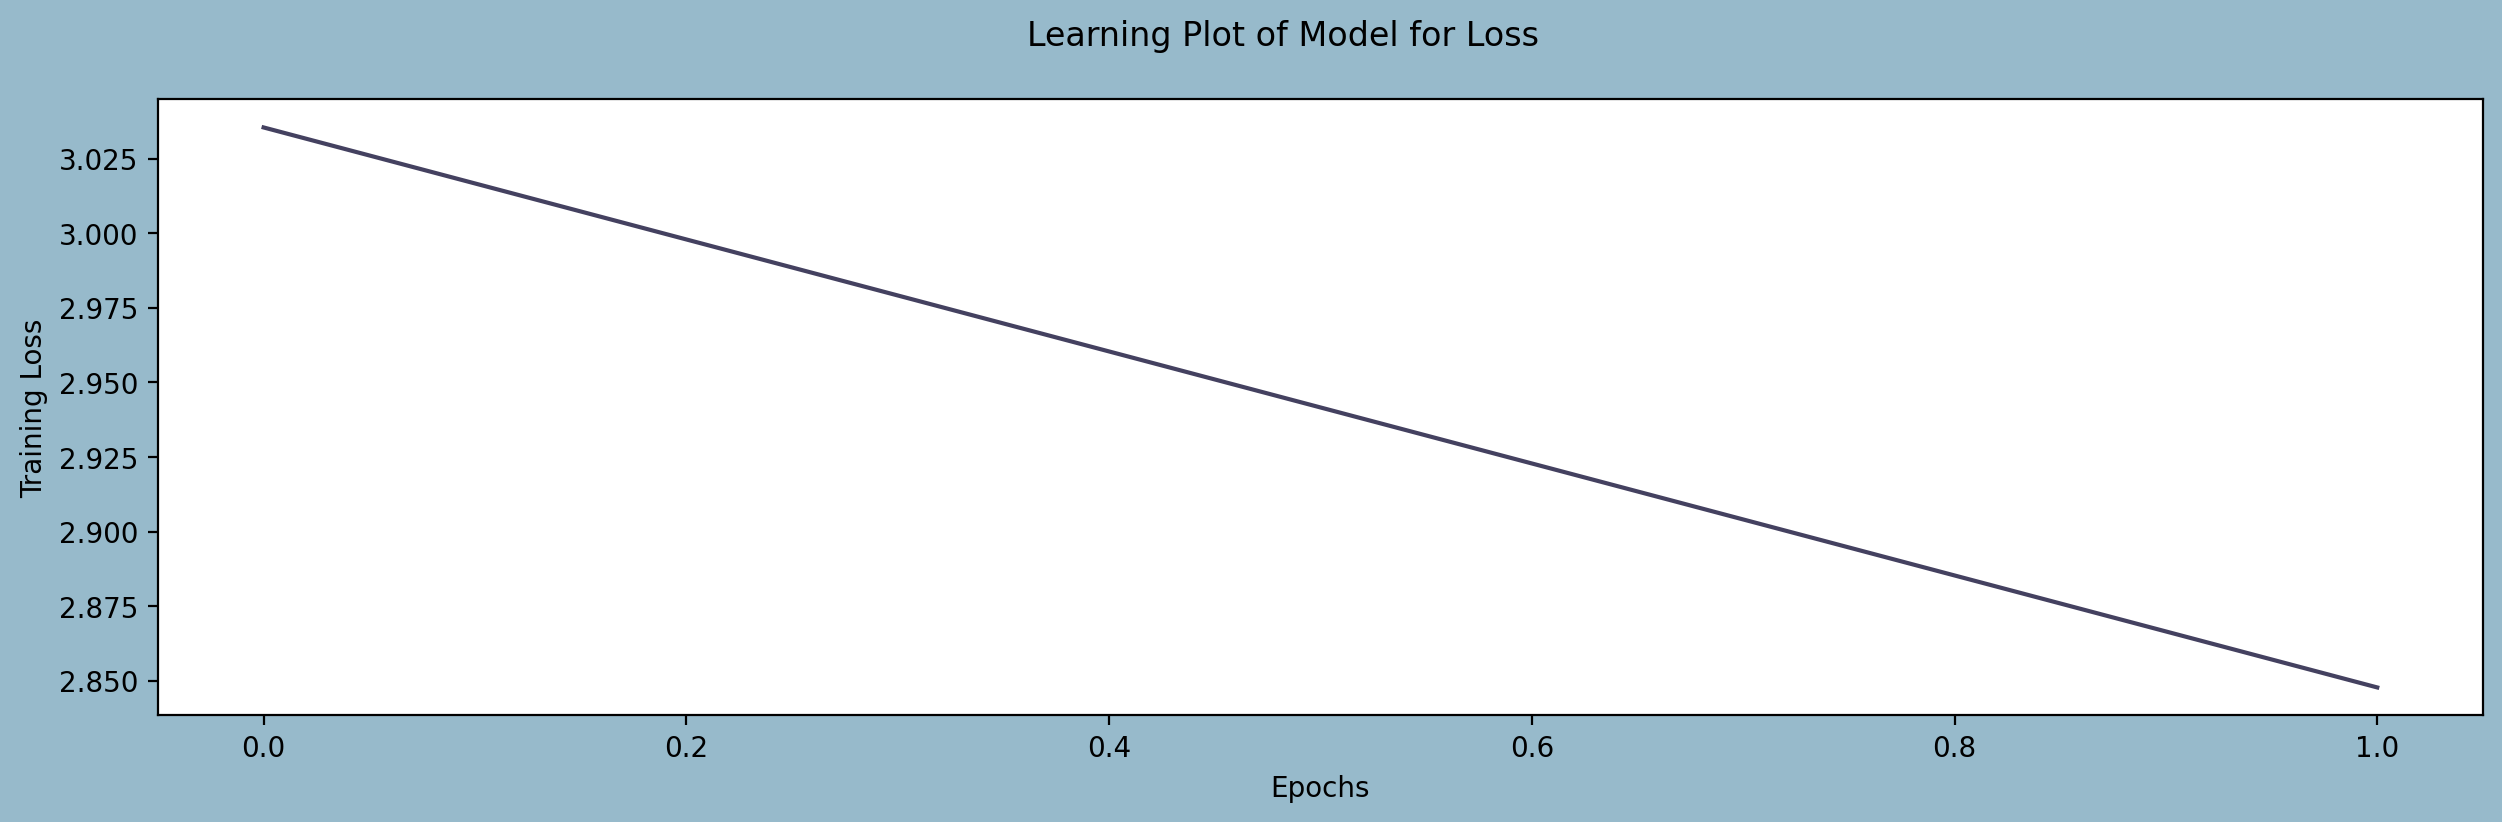

In [25]:
# Plot learning via loss function
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

**Part 5: Generate sample music from input seed**

In [26]:
seed = X_seed[np.random.randint(0,len(X_seed)-1)]
Music = ""
Notes_Generated = []

for i in range(100):
    seed = seed.reshape(1,length,1)
    prediction = model.predict(seed, verbose=0)[0]
    prediction = np.log(prediction) / 1.0 #diversity
    exp_preds = np.exp(prediction)
    prediction = exp_preds / np.sum(exp_preds)
    index = np.argmax(prediction)
    index_N = index/ float(L_symb)   
    Notes_Generated.append(index)
    Music = [reverse_mapping[char] for char in Notes_Generated]
    seed = np.insert(seed[0],len(seed[0]),index_N)
    seed = seed[1:]

NameError: name 'L_symb' is not defined

**Part 6: Reverse map output to musical notation and form MIDI file**

In [22]:
# function that will convert char in produced sequence string back to note notation.
# note that here, we omit flats, because we can represent all flat pitches as sharps as well
# i.e. A flat is the same as G#, Db is the same as C#
def oldReverseMap(char):
    notes = {
        '@': 'C2', '#': 'C#2', '$': 'D2', '%': 'D#2', '^': 'E2', '&': 'F2', '*': 'F#2',
        '(': 'G2', ')': 'G#2', '_': 'A2', '+': 'A#2', '-': 'B2',
        
        'q': 'C3', 'w': 'C#3', 'e': 'D3', 'r': 'D#3', 't': 'E3', 'y': 'F3', 'u': 'F#3',
        'i': 'G3', 'o': 'G#3', 'p': 'A3', '[': 'A#3', ']': 'B3',
        
        'a': 'C4', 's': 'C#4', 'd': 'D4', 'f': 'D#4', 'g': 'E4', 'h': 'F4', 'j': 'F#4',
        'k': 'G4', 'l': 'G#4', ';': 'A4', '?': 'A#4', 'z': 'B4',
        
        'x': 'C5', 'c': 'C#5', 'v': 'D5', 'b': 'D#5', 'n': 'E5', 'm': 'F5', ',': 'F#5',
        '.': 'G5', '/': 'G#5', 'Q': 'A5', 'W': 'A#5', 'E': 'B5',
        
        'R': 'C6', 'T': 'C#6', 'Y': 'D6', 'U': 'D#6', 'I': 'E6', 'O': 'F6', 'P': 'F#6',
        '{': 'G6', '}': 'G#6', '|': 'A6', 'A': 'A#6', 'S': 'B6',
        
        'D': 'C7', 'F': 'C#7', 'G': 'D7', 'H': 'D#7', 'J': 'E7', 'K': 'F7', 'L': 'F#7',
        ':': 'G7', '"': 'G#7', 'Z': 'A7', 'X': 'A#7', 'C': 'B7',
        
        'V': 'C8'
    }
    return notes.get(char, char)

In [37]:
def reverseMap(note):
    
    reverseNoteMapping = {
        0: 'C2', 1: 'C#2', 2: 'D2', 3: 'D#2', 4: 'E2', 5: 'F2', 6: 'F#2',
        7: 'G2', 8: 'G#2', 9: 'A2', 10: 'A#2', 11: 'B2', 12: 'C3', 13: 'C#3',
        14: 'D3', 15: 'D#3', 16: 'E3', 17: 'F3', 18: 'F#3', 19: 'G3', 20: 'G#3',
        21: 'A3', 22: 'A#3', 23: 'B3', 24: 'C4', 25: 'C#4', 26: 'D4', 27: 'D#4',
        28: 'E4', 29: 'F4', 30: 'F#4', 31: 'G4', 32: 'G#4', 33: 'A4', 34: 'A#4',
        35: 'B4', 36: 'C5', 37: 'C#5', 38: 'D5', 39: 'D#5', 40: 'E5', 41: 'F5',
        42: 'F#5', 43: 'G5', 44: 'G#5', 45: 'A5', 46: 'A#5', 47: 'B5', 48: 'C6',
        49: 'C#6', 50: 'D6', 51: 'D#6', 52: 'E6', 53: 'F6', 54: 'F#6', 55: 'G6',
        56: 'G#6', 57: 'A6', 58: 'A#6', 59: 'B6', 60: 'C7', 61: 'C#7', 62: 'D7',
        63: 'D#7', 64: 'E7', 65: 'F7', 66: 'F#7', 67: 'G7', 68: 'G#7', 69: 'A7',
        70: 'A#7', 71: 'B7', 72: 'C8', 73: 'C#8', 74: 'D8', 75: 'D#8', 76: 'E8',
        77: 'F8', 78: 'F#8', 79: 'G8', 80: 'G#8', 81: 'A8', 82: 'A#8', 83: 'B8',
        84: 'B-1', 85: 'A0', 86: 'A#0', 87: 'B0', 88: 'C1', 89: 'C#1', 90: 'D1',
        91: 'D#1', 92: 'E1', 93: 'E-1', 94: 'F1', 95: 'F#1', 96: 'G1', 97: 'G#1',
        98: 'A1', 99: 'B-0', 100: 'B1',
    }
    
    return reverseNoteMapping.get(note, note)

In [60]:
#sample output array, change to actual output produced by model.
outputArray = [36, 38, 40, 41, 43, 45, 47, 48]

In [61]:
# convert output string chars back to music notation
notes = []
for item in outputArray:
    notes.append(reverseMap(item))

# create MIDI file
noteStream = stream.Stream()

for n in notes:
    noteObj = note.Note(n)
    noteStream.append(noteObj)

noteStream.append(tempo.MetronomeMark(number=120))
midiFile = noteStream.write('midi', fp='test.mid')

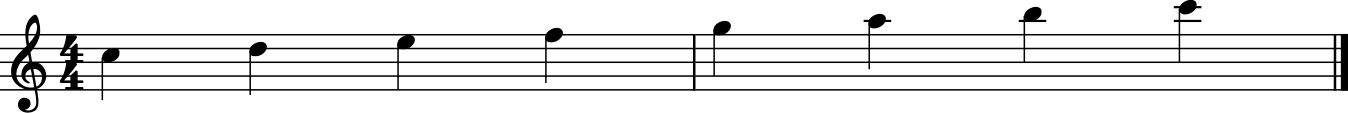

In [62]:
# Load MIDI file using Music21
midiStream = converter.parse('test.mid')

# show musical notation
midiStream.show()

In [59]:
# produce playable audio
midiStream.show("midi")